<a href="https://colab.research.google.com/github/parthsarthi0411/text_Classification/blob/master/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**"Text Classification"** is a common business problem solved under the umbrella of Natural Language Processing. The goal is to automatically classify a given text into one or more predefined categories. 

The given dataset (JSON file) has about 10.000 sentences (key: text) each belonging to a particular category (key: label). (Job requirements categorized on technical, softskills and others)

The challenge is broken into several tasks which are as below:


In [0]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

**Task 1**: Read the file and prepare the data or text classification (take decisions on how to clean the data, what to do with punctuation signs or special characters, etc.)


We first import the data from json file into a pandas Dataframe.

In [0]:
import pandas as pd

path_to_json = 'tech_soft_none.json'
data = pd.read_json(path_to_json,orient='split') 

**Cleaning the data:** Machines read differently than humans. While a well-punctuated text eases the readability for us, it does quite the opposite for dear old machines. We will therefore start with cleaning the data of all the special signs (e.g. @,&,% etc.) and punctuation marks (e.g. !,; etc.).

Removing puncuation marks via str.translate function and an inbuilt list of marks under string.punctuations. 




In [23]:
'''
Python string method translate() returns a copy of the string in which all characters have been translated using table (constructed with the maketrans() function in the string module), optionally deleting all characters found in the string deletechars.
Syntax : maketrans(str1, str2, str3)
Parameters :
str1 : Specifies the list of characters that need to be replaced.
str2 : Specifies the list of characters with which the characters need to be replaced.
str3 : Specifies the list of characters that needs to be deleted.

string.punctuation = !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
'''

df['CleanData'] = df['text'].str.translate(str.maketrans('','',string.punctuation))

df['CleanData'][0]

'Standort Trovarit AG München Deutschland'

**Task 2**: Train a classification model that takes a sentence and predicts the class it belongs to. You are free to use any type of model or libraries for this task.

In [0]:
#moving to a new dataframe

trainDF = pandas.DataFrame()
trainDF['text'] = df['CleanData']
trainDF['label'] = df['label']

Before we start developing a classification model, it is imporatnt to split the data into separate training and validation sets. One would be used for training the model and the other to test the trained model.

Splitting the dataset into training and validation sets.

In [0]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

At first we have to transform the raw text data into feature vectors. There are several methods used for this like count vectors, TF-IDF vectors, word embeddings etc. 

We start experimenting with TF-IDF vectors as features. A TF-IDF score represents the relative importance of a term in the document and the entire corpus. It is composed of two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams). We chose N-grams that is the combination of N terms together.

In [0]:
#TF-IDF Vectors as features

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

**Building and Saving the Model**


The next step is to train a classifier using the features created in the previous step. Here again, there are several models that are used for text classification. We first implemtment the Naive Bayes Classifier and then one based on Support Vector Machine. 

In [0]:
import joblib
#utiliy function for different classifiers. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed. 

def train_model(classifier, feature_vector_train, label, feature_vector_valid, model_type, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # save the trained model in the "models" folder
    joblib.dump(classifier, 'models/' + model_type + '.pkl') 
    print ("model saved")
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

Naive Bayes Model.

In [53]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, 'bayes')
print ("NB, N-Gram Vectors: ", accuracy)

model saved
NB, N-Gram Vectors:  0.9012875536480687


Support Vector Machine Model

In [46]:
#SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, 'svm')
print ("SVM, N-Gram Vectors: ", accuracy)

model saved
SVM, N-Gram Vectors:  0.8993367147873585


The models built on Naive Bayes and SVM give staisfactory results with an accuracy around 90%. Now we attempt a more sophisticated neural networks based approach to develop a classification model.

The Recurrent Neural Networks, and more specifically a sub-type called LSTMs (Long Short Term Memory) are widely used in NLP problems as they have a sense of memory and can retain the information from previous states. We now try to train an LSTM based model for text classification.

In the previous step we had transformed the raw text data into feature vectors in form of TF-IDF. These features were later used in Naive Bayes and SVM classification models. However, these features are not compatible to a neural network and thus cannot be fed to our LSTM model. 

We have to transform our raw data in to Word Embeddings (representing words using vectors) to feed it to the LSTM. We are going to use a pre-trained word embedding called Word2Vec. In the following section we are loading the embeddings.

In [0]:
import gensim, re
import numpy as np
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

text = [re.sub(r'([^\s\w]|_)+', '', sentence) for sentence in trainDF['text']]
text = [sentence.lower().split() for sentence in text]

word_model = gensim.models.Word2Vec(text, size=300, min_count=1, iter=10)

#Embedding Matrix
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(word_model.wv.vocab) + 1, 300))
for i, vec in enumerate(word_model.wv.vectors):
  embedding_matrix[i] = vec


In this step we are tokenizing the text, i.e splitting the text into individual words.

In [0]:
#Tokenising for LSTM

# how many features should the tokenizer extract
features = 500
tokenizer = Tokenizer(num_words = features)
# fit the tokenizer on our text
tokenizer.fit_on_texts(trainDF['text'])

# get all words that the tokenizer knows
word_index = tokenizer.word_index

# put the tokens in a matrix
X = tokenizer.texts_to_sequences(trainDF['text'])
X = pad_sequences(X)

# prepare the labels
y = pd.get_dummies(trainDF['label'])

# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

Now we create the LSTM model. It is sequential. We initially use a layer to pass the embeddings which is followed by an LSTM layer and in the end a dense layer which does the classification. 

In [0]:
#LSTM MODEL 
from keras import backend as K
# init model
model = Sequential()
# emmbed word vectors
model.add(Embedding(len(word_model.wv.vocab)+1,300,input_length=X.shape[1],weights=[embedding_matrix],trainable=False))
# learn the correlations
model.add(LSTM(300,return_sequences=False))
model.add(Dense(y.shape[1],activation="softmax"))
# output model skeleton
# model.summary()

# evaluation functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['acc',f1_m,precision_m, recall_m])

# optimizer "adam" is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks.
# The algorithms leverages the power of adaptive learning rates methods to find individual learning rates for each parameter

After this we train the model for 12 epochs (number of complete passes through the training dataset) with a batch size (number of samples processed before the model is updated) 32. The test and train split is 75/25.

Train on 6918 samples, validate on 2306 samples
Epoch 1/12
6918/6918 [==============================] - 167s 24ms/step - loss: 0.8044 - acc: 0.6385 - f1_m: 0.5825 - precision_m: 0.7105 - recall_m: 0.5121 - val_loss: 0.6995 - val_acc: 0.7285 - val_f1_m: 0.7079 - val_precision_m: 0.7638 - val_recall_m: 0.6618
Epoch 2/12
6918/6918 [==============================] - 160s 23ms/step - loss: 0.5777 - acc: 0.7699 - f1_m: 0.7586 - precision_m: 0.8081 - recall_m: 0.7165 - val_loss: 0.6490 - val_acc: 0.7689 - val_f1_m: 0.7367 - val_precision_m: 0.8086 - val_recall_m: 0.6800
Epoch 3/12
6918/6918 [==============================] - 160s 23ms/step - loss: 0.5043 - acc: 0.7962 - f1_m: 0.7928 - precision_m: 0.8348 - recall_m: 0.7561 - val_loss: 0.6068 - val_acc: 0.7788 - val_f1_m: 0.6607 - val_precision_m: 0.7783 - val_recall_m: 0.5950
Epoch 4/12
6918/6918 [==============================] - 159s 23ms/step - loss: 0.4629 - acc: 0.8173 - f1_m: 0.8106 - precision_m: 0.8475 - recall_m: 0.7783 - val_loss: 0

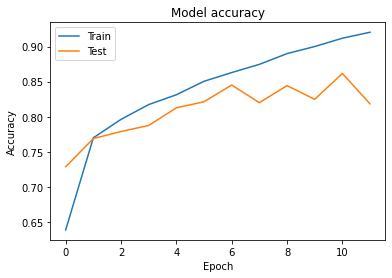

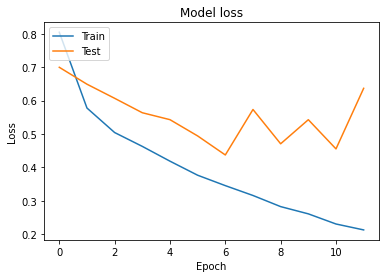

In [111]:
#Plotting Code

import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, validation_split=0.25, epochs=12, batch_size=32, verbose=1)

#saving the model
model.save('models/lstm.h5')

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Task 3:** Provide evaluation metrics about the trained model, eventually visualize the results.

Two graphs are plot showing accuracy and loss noted on test and training data in the course of 12 epochs. Some evaluation metrics for training data are:

1. Loss: 0.2130
2. Accuracy: 0.9205
3. F1_score: 0.9194
4. Precision: 0.9338
5. Recall: 0.9060

In [114]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

Loss: 0.8893659609347219
Accuracy: 0.7609756097560976
F1_score: 0.7581864369206313
Precision: 0.7862089239678732
Recall: 0.7326829267129665


**Task 4:** Explain your results: Is it a good model, what would you do to improve the model.

Evauation metrics for test dataset are:
1. Loss: 0.8893659609347219
2. Accuracy: 0.7609756097560976
3. F1_score: 0.7581864369206313
4. Precision: 0.7862089239678732
5. Recall: 0.7326829267129665

Loss is defined as the difference between the predicted value by your model and the true value while accuracy is number of correct predictions by total number of prediction. The model had a low loss and high accuracy for the training dataset but losses rose higher for the test data. This means our model's predictions are far from true values. 

F1_Score is another measure to test accuracy. It is defined as the weighted harmonic mean of the test’s precision and recall. Our model has high F1_score for both training and test datasets.

Precision is defined as the number of true positives over the number of true positives plus the number of false positives, whereas, Recall is defined as the number of true positives over the number of true positives plus the number of false negatives. Both these values are also about average for the model.

However, there is still a lot of scope for improvement. We used the simplest form of an LSTM. More hidden layers can be added to the network to enhance its efficiency. A change in hyperparameters can also give better results. The enhacements are discussed in detail later. 

**Task 5:** Bonus 1 (optional): Share the trained model as an application. It can be a command line application or any other format that can be executed (it doesn't matter the OS, I have access to Linux, MacOS, and Windows)

The notebook provides an inbuilt application to access the trained models. The user can enter a statement and a model (lstm, bayes, and svm). The classification would be done based on the models and result would be displayed.

In [0]:
'''
Function to read user input and classify it to one of the three classes.
[0] None / Others
[1] Softskills 
[2] Technical
'''
def text_classification(input_text, model_type):
  from keras.models import load_model

  if model_type in ('lstm', 'LSTM'):
    #reading the saved model
    new_model = load_model('models/' + model_type + '.h5')
    #tokenizing the input text
    X1 = tokenizer.texts_to_sequences([input_text])
    #padding with zeros if the input sequence is smaller than 121 which is the max length of sentences in the dataset
    X1 = pad_sequences(X1, maxlen=121)
    result = new_model_lstm.predict_classes(X1,verbose = 0)
  else:
    #reading the saved model
    new_model = joblib.load('models/' + model_type + '.pkl')

    test_df = pd.Series(data=input_text) #Series is the data structure for a single column of a DataFrame

    xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_df)

    result = new_model.predict(xtest_tfidf_ngram)

  #none = [0], soft=[1], tech=[2]
  #print(result)
  if np.array_equal(result, [1]):
    print("You are talking about a Softskill")
  elif np.array_equal(result, [2]):
    print("You are talking about Technical competencies")
  else:
    print("You've surprized us! We don't know what you are talking about.")

**Run this section to interact with the application.**

In [118]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

style = {'description_width': 'initial'}

input_text = widgets.Text(description="What statement do you have for us?", width=500, style=style)

def pass_text(sender):
  text_classification(input_text.value, model_type.value)

input_text.on_submit(pass_text)

model_type = widgets.Dropdown(description="Which model shall we test it on?", width=500, options=["svm", "lstm","bayes"], style=style)

display(model_type)
display(input_text)


Dropdown(description='Which model shall we test it on?', options=('svm', 'lstm', 'bayes'), style=DescriptionSt…

Text(value='', description='What statement do you have for us?', style=DescriptionStyle(description_width='ini…

You are talking about a Softskill


**Task 6:** Bonus 2 (optional): Suggest some improvements for the future.

Eventhough our LSTM model was able to do pretty well, there is always a room of improvement.

During the feature extraction section, we used N- grams for our SVM and Naive Bayes classifier and Word embeddings for the LSTM Network. We believe that combining the two set of features could potentially improve the accuracy of the classifier.

Another suggestion would be to use ensemble models. We described three different models for text classification. By stacking different models and combining their outputs, we might have better results.

Finally, as is the case with most of the Machine Learning problems - the hyperparameters play an important role in training a good classifier. We could further tune these hyperparamaters to enhance the results of our classifier.